https://blog.paperspace.com/image-segmentation-using-segmentation_models_pytorch/

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"denisegorov","key":"ec36751b6b2a254da4471aad1bef3be2"}'}

In [2]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 67 Jul 17 10:15 kaggle.json


In [3]:
!pip install -q kaggle

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets list -s set-lipstick-original

ref                                           title                                     size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------  ----------------------------------------  ----  -------------------  -------------  ---------  ---------------  
olekslu/makeup-lips-segmentation-28k-samples  Makeup. Pixel Perfect Lips Segmentation.   2GB  2020-06-10 09:00:21           1231         25  0.9411765        
mantasu/face-attributes-grouped               Face Attributes Grouped                    2GB  2023-06-06 11:27:43            104         14  0.75             


In [7]:
! kaggle datasets download olekslu/makeup-lips-segmentation-28k-samples

100% 2.38G/2.38G [00:21<00:00, 120MB/s]
100% 2.38G/2.38G [00:21<00:00, 119MB/s]


In [8]:
! mkdir dataset

In [9]:
! unzip makeup-lips-segmentation-28k-samples.zip -d dataset

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: dataset/set-lipstick-original/mask/mask00023595.png  
  inflating: dataset/set-lipstick-original/mask/mask00023596.png  
  inflating: dataset/set-lipstick-original/mask/mask00023597.png  
  inflating: dataset/set-lipstick-original/mask/mask00023598.png  
  inflating: dataset/set-lipstick-original/mask/mask00023599.png  
  inflating: dataset/set-lipstick-original/mask/mask00023600.png  
  inflating: dataset/set-lipstick-original/mask/mask00023601.png  
  inflating: dataset/set-lipstick-original/mask/mask00023602.png  
  inflating: dataset/set-lipstick-original/mask/mask00023603.png  
  inflating: dataset/set-lipstick-original/mask/mask00023604.png  
  inflating: dataset/set-lipstick-original/mask/mask00023605.png  
  inflating: dataset/set-lipstick-original/mask/mask00023606.png  
  inflating: dataset/set-lipstick-original/mask/mask00023607.png  
  inflating: dataset/set-lipstick-original/mask/mask00023608.

In [10]:
! rm -R makeup-lips-segmentation-28k-samples.zip

In [11]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import matplotlib.pyplot as plt

In [12]:
! pip install segmentation_models_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 38.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.7 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=fa9f022fd6e3f48e79dff005a376ffa73f9bacdcb7633cc6e897cea4d7a029e3
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=18c0363a872d067094ccc0a8a64b638abea1dca90361b1016424ba0d19086780
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c6

In [13]:
import segmentation_models_pytorch as smp

In [74]:
list_df_path = '/content/dataset/set-lipstick-original/list.csv'
list_df = pd.read_csv(list_df_path)

In [75]:
list_df.tail(5)

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
28589,image00028590.jpg,1280,720,Lips,657,347,817,450,mask00028590.png
28590,image00028591.jpg,1280,720,Lips,713,325,884,388,mask00028591.png
28591,image00028592.jpg,1280,720,Lips,659,401,808,488,mask00028592.png
28592,image00028593.jpg,1280,720,Lips,689,334,839,431,mask00028593.png
28593,image00028594.jpg,1280,720,Lips,657,381,817,476,mask00028594.png


In [76]:
list_df = list_df.head(1000)

In [77]:
len(os.listdir('/content/dataset/set-lipstick-original/720p'))

28594

In [78]:
len(os.listdir('/content/dataset/set-lipstick-original/mask')) # упс, проблема

28540

In [79]:
mask_list = os.listdir('/content/dataset/set-lipstick-original/mask')
for i in range(len(list_df)):
  if list_df["mask"][i] not in mask_list:
    list_df.drop(i, axis=0, inplace=True)

In [80]:
len(list_df)

1000

In [81]:
list_df.reset_index(drop=True, inplace=True)

In [82]:
list_df.tail(3)

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
997,image00000998.jpg,1280,720,Lips,700,337,788,405,mask00000998.png
998,image00000999.jpg,1280,720,Lips,679,337,762,389,mask00000999.png
999,image00001000.jpg,1280,720,Lips,667,359,749,412,mask00001000.png


In [83]:
list_df.loc[10, 'mask']

'mask00000011.png'

In [84]:
list_df['filename'][:2000]

0      image00000001.jpg
1      image00000002.jpg
2      image00000003.jpg
3      image00000004.jpg
4      image00000005.jpg
             ...        
995    image00000996.jpg
996    image00000997.jpg
997    image00000998.jpg
998    image00000999.jpg
999    image00001000.jpg
Name: filename, Length: 1000, dtype: object

In [85]:
list_df['class'].unique()

array(['Lips'], dtype=object)

In [86]:
list_df['width'].unique()

array([1280])

In [87]:
list_df['height'].unique()

array([720])

Зафиксирую все возможные случайности

In [88]:
def seed_everything(seed):
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42)

Сделаем свой класс. В инициализации буду нужно обозначить папку входных изображений, папку для вывода, трансформ да/нет, и трейн/тест. Разделение на трейн и тест 80/20 выборки во время инициализации чтобы потом не думать.  
__len__ возвращает длину датасета

__getitem__ создает путь к конкретной картинке приклеивая название картинки к пути рабочей папки, делает то же самое для маски. Если задана аугментация - выполняет аугментацию

In [89]:
class SegmentationDataset(Dataset):
    def __init__(self, input_dir, output_dir, is_train, transform=None):
        self.input_dir  = input_dir
        self.output_dir = output_dir
        self.transform  = transform
        #x = round(len(os.listdir(input_dir)) * .8)
        x = round(len(list_df) * .8)
        if is_train == True:
            # self.images = os.listdir(input_dir)[:x] почему-то путает порядок, сделаю через датафрейм
            # self.masks = os.listdir(output_dir)[:x]
            self.images = list_df['filename'][:x]
            self.masks = list_df['mask'][:x]
        else:
            # self.images = os.listdir(input_dir)[x:]
            # self.masks = os.listdir(output_dir)[x:]
            self.images = list_df['filename'][x:].reset_index(drop=True)
            self.masks = list_df['mask'][x:].reset_index(drop=True)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path    = os.path.join(self.input_dir, self.images[index])
        mask_path   = os.path.join(self.output_dir, self.masks[index])
        img         = np.array(Image.open(img_path).convert("RGB"), dtype=np.float32) / 255
        mask        = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)   / 255

        if self.transform is not None:
            augmentations = self.transform(image=img, mask=mask)
            img   = augmentations["image"]
            mask  = augmentations["mask"]

        return img, mask

In [90]:
TRAIN_INP_DIR = '/content/dataset/set-lipstick-original/720p'
TRAIN_OUT_DIR = '/content/dataset/set-lipstick-original/mask'
DEVICE        = "cuda" if torch.cuda.is_available() else "cpu"

LEARNING_RATE = 3e-4
BATCH_SIZE    = 64
NUM_EPOCHS    = 10
IMAGE_HEIGHT  = 160
IMAGE_WIDTH   = 256

train_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.ColorJitter(p=0.2),
        A.HorizontalFlip(p=0.5),
        ToTensorV2(),
    ],
)

val_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        ToTensorV2(),
    ],
)

In [91]:
def get_loaders( inp_dir, mask_dir,batch_size,
			     train_transform, val_tranform ):

    train_ds     = SegmentationDataset( input_dir=inp_dir, output_dir=mask_dir,
                            is_train=True, transform=train_transform)

    train_loader = DataLoader( train_ds, batch_size=batch_size, shuffle=True )

    val_ds       = SegmentationDataset( input_dir=inp_dir, output_dir=mask_dir,
                            is_train=False, transform=val_transform)

    val_loader   = DataLoader( val_ds, batch_size=batch_size, shuffle=True  )

    return train_loader, val_loader

Проверка как это все работает

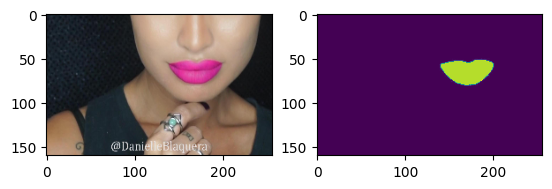

In [92]:
train_loader, val_loader = get_loaders( TRAIN_INP_DIR, TRAIN_OUT_DIR,
                            BATCH_SIZE,  train_transform, val_transform)
inputs, masks = next(iter(train_loader))

_, ax = plt.subplots(1,2)
ax[0].imshow(inputs[0].permute(1,2,0))
ax[1].imshow(masks[0])

Функция для подсчета accuarcy. Использую pixel accuracy и метрику Дайса. В качестве функции активации использую сигмоиду, так как тут по сути бинарная классификация. Выход из конверитрую - все что ниже 0.5 приравниваю к 0, выше - к 1. Дальше делю количество правильно предсказанных пикселей на общее количесвто пикселей, получаю accuracy, потом считаю метрику Дайса.

In [93]:
def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    num_pixels  = 0
    dice_score  = 0
    model.eval()

    with torch.no_grad():
        for img, mask in tqdm(loader):
            img   = img.to(device)
            mask  = mask.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(img))
            preds = (preds > 0.5).float() # здесь получатся значения True или False, через .float конвертирую их в 0.0 или 1.1
            num_correct += (preds == mask).sum()
            num_pixels += torch.numel(preds) # возвращает количество элементов тензора
            dice_score += (2 * (preds * mask).sum()) / ((preds + mask).sum() + 1e-7) # поправочный коэффициент чтобы не делить на ноль

    print(
        f"Got {num_correct}/{num_pixels} with pixel accuracy {num_correct/num_pixels*100:.2f}"
    )
    print(f"Dice score: {dice_score/len(loader)*100:.2f}")
    model.train()

Использую Unet, которая изначально вроде бы разрабатывалась для семантической сегментации медицинских изображений. В качестве функции потери - бинарная кроссэнтропия, т.к. у нас бинарная классификация. Без активации потому что у меня в chek_accuracy сигмоида.

In [94]:
model = smp.Unet(encoder_name='efficientnet-b3', in_channels=3, classes=1, activation=None).to(DEVICE)
loss_fn   = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [95]:
def train_fn(loader, model, optimizer, loss_fn):
    loop = tqdm(loader)

    for batch_idx, (image, mask) in enumerate(loop):
        image   = image.to(device=DEVICE)
        mask    = mask.float().unsqueeze(1).to(device=DEVICE)

        # forward
        predictions = model(image)
        loss = loss_fn(predictions, mask)

        # backward
        model.zero_grad()
        loss.backward()
        optimizer.step()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())

проверка рабботоспособности до обучения

In [96]:
check_accuracy(val_loader, model, device=DEVICE)


100%|██████████| 4/4 [00:06<00:00,  1.62s/it]

Got 391323/8192000 with pixel accuracy 4.78
Dice score: 0.30


На пиксельную аккуратность пока не обращаю внимания, потом на что-нибудь поменяю. У нее очень высокий показатель из-за того что пикселей класса 1 очень мало по сравнению с классом 0, поэтому даже если абсолютно везде промахнуться с прогнозом - accuracy будет больше 90%/  

In [97]:
for epoch in range(5):

    print('########################## epoch: '+str(epoch))
    train_fn(train_loader, model, optimizer, loss_fn)

    # check accuracy
    check_accuracy(val_loader, model, device=DEVICE)

########################## epoch: 0


100%|██████████| 4/4 [00:06<00:00,  1.65s/it]


Got 6299209/8192000 with pixel accuracy 76.89
Dice score: 1.03
########################## epoch: 1


100%|██████████| 4/4 [00:06<00:00,  1.61s/it]


Got 7452323/8192000 with pixel accuracy 90.97
Dice score: 0.68
########################## epoch: 2


100%|██████████| 4/4 [00:05<00:00,  1.46s/it]


Got 7966454/8192000 with pixel accuracy 97.25
Dice score: 0.08
########################## epoch: 3


100%|██████████| 4/4 [00:05<00:00,  1.42s/it]


Got 8138773/8192000 with pixel accuracy 99.35
Dice score: 0.00
########################## epoch: 4


100%|██████████| 4/4 [00:05<00:00,  1.37s/it]

Got 8148382/8192000 with pixel accuracy 99.47
Dice score: 0.00


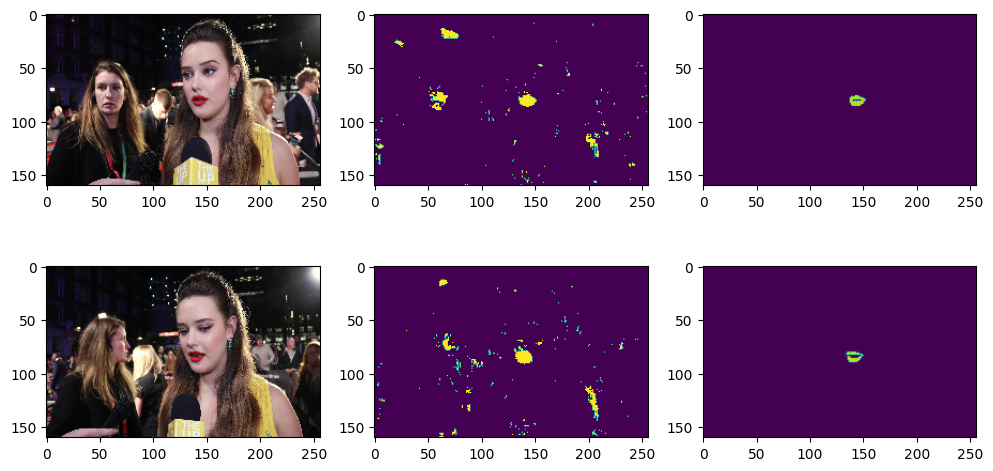

In [98]:
inputs, masks = next(iter(val_loader))
output        = ((torch.sigmoid(model(inputs.to('cuda')))) >0.5).float()
_, ax = plt.subplots(2,3, figsize=(12,6))
for k in range(2):
    ax[k][0].imshow(inputs[k].permute(1,2,0))
    ax[k][1].imshow(output[k][0].cpu())
    ax[k][2].imshow(masks[k])